In [1]:
# load some necessary modules
from dmipy.core import modeling_framework
from os.path import join
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#load the example data
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [4]:
#setup ball and stick model
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
ballstick = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing pathos to take advantage of multicore processing.


In [5]:
import asyncio
from importlib import reload

import fit_bayes
from fit_bayes import fit, tform_params  # , dict_to_array, array_to_dict
fit_bayes = reload(fit_bayes)


In [6]:
#things to note/change in the code:
#remove tqdm
#roi extraction in lines 60-65 doesn't work if 3D array and/or not reshaped
#it fails when the burn in is too small (e.g. 200 steps, 100 burn in), line 162 fails




In [7]:
#setup stuff - want to move this inside the function

#get the mask
mask_hcp = (data_hcp[..., 0]>0)

#MAKE THE MASK A BIT SMALLER FOR TESTING
#mask_hcp[23:-1,:,:] = 0

#squash down into a 2D array - single slice
mask = np.squeeze(mask_hcp)
data = np.squeeze(data_hcp)

#reshape the data
nx = data.shape[0]
ny = data.shape[1]
ndw = data.shape[2]

from copy import copy, deepcopy
# generalise
model = deepcopy(ballstick)
data = np.reshape(data_hcp, (nx*ny, ndw))
mask = np.reshape(mask_hcp, nx*ny)
    

# #in future, want to add account fot 3D array, something like this  
# #reshape the data
# nx = data_hcp.shape[0]
# ny = data_hcp.shape[1]
# nz = data_hcp.shape[2]
# ndw = data_hcp.shape[3]

# # generalise
# #model = deepcopy(BAS_mod)
# data = np.reshape(data_hcp, (nx*ny*nz, ndw))
# mask = np.reshape(mask_hcp, nx*ny*nz)  


In [9]:
nsteps=500
burn_in=250

acceptance_rate, param_conv, params_all_new, params_all_orig, likelihood_stored, w_stored = fit_bayes.fit(ballstick, scheme_hcp, data, mask, nsteps, burn_in)


Setup brute2fine optimizer in 1.8963332176208496 seconds
Fitting of 8181 voxels complete in 391.5802619457245 seconds.
Average of 0.04786459625299162 seconds per voxel.
ROI [0]
ROI vals [1]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


/Users/paddyslator/dmipy-bayesian/fit_bayes.py:303: RuntimeWarning: divide by zero encountered in true_divide
  w[param][idx_roi] = w[param][idx_roi] * 101 / (2 * (101 - (accepted_per_100[param][idx_roi])))


101


/Users/paddyslator/dmipy-bayesian/fit_bayes.py:223: RuntimeWarning: divide by zero encountered in log
  f_dept = np.log(f_dept) - np.log(1 - f_dept)  # tform dept fraction (orig -> log)
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:34: RuntimeWarning: invalid value encountered in true_divide
  param_dict[param] = (lb + ub * np.exp(param_dict[param])) / (1 + np.exp(param_dict[param]))
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:248: RuntimeWarning: divide by zero encountered in log
  prior_new = prior_new + np.log(scipy.stats.multivariate_normal.pdf(parameter_vector, mu, sigma, allow_singular=1))


102


/Users/paddyslator/dmipy-bayesian/fit_bayes.py:217: RuntimeWarning: invalid value encountered in true_divide
  f_indep = np.exp(f_indep) / (1 + np.exp(f_indep))  # tform indept fractions (log -> orig)


103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352


IndexError: tuple index out of range

In [10]:
#lsq fit for comparison (could output this from the fit_bayes function?)
BAS_fit_hcp = ballstick.fit(scheme_hcp, data, mask)


Setup brute2fine optimizer in 0.5807089805603027 seconds
Fitting of 8181 voxels complete in 413.1239228248596 seconds.
Average of 0.050497973698186 seconds per voxel.


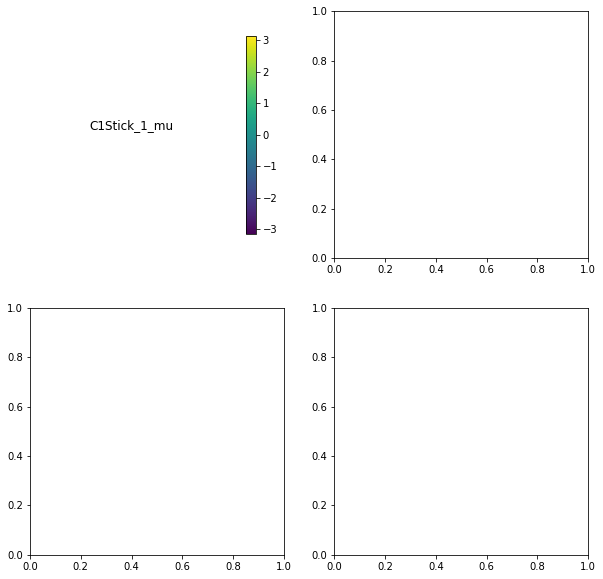

In [11]:
#TO DO plot lsq and Bayesian fit maps 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fitted_parameters = BAS_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1



In [ ]:
#TO DO plot some example MCMC chains

In [ ]:
#TO DO plot the inferred prior distributions
import scipy.stats as stats

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

names = ['D_par','D_iso','f_stick','inclination (0,$\pi$)','azimuth (-$\pi$,$\pi$)']


for i in range(0,5):
    marginal_mu = mu[i]
    variance = sigma[i,i]
    marginal_sigma = math.sqrt(variance)
    x = np.linspace(marginal_mu - 3*marginal_sigma, marginal_mu + 3*marginal_sigma, 100)
    axs[i].plot(x, stats.norm.pdf(x, marginal_mu, marginal_sigma))
    axs[i].set_title(names[i])
 